In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from astropy.table import Table
from astropy.io import fits
from sky import fit_gauss, gauss
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms
import torchvision.datasets as dset
from kymatio.torch import Scattering2D
import tqdm
import shutil
from matplotlib.colors import ListedColormap, TABLEAU_COLORS
import os

In [2]:
# SDSS galaxies
sdss_table = Table.read('SDSS_allGZ_BPT_final_bt.csv', format='ascii.csv')
# TNG galaxies
tng_table = Table.read('merger_table_upto_25_fullinfo.csv', format='ascii.csv')

# paths to where I have images stored (plus file prefixes)
# these are changed to reflect the images I have sent
sdss_prefix = 'sdss/reprojected_'
tng_prefix = 'tng/FullReal_8R_'

# filter tables by what images I have
tng_table = tng_table[tng_table['selected'] == 1]
sdss_table = sdss_table[sdss_table['downloaded'] == 1]

In [3]:
# get some data we'll use a lot since the names are different
sdss_ids = sdss_table['objid']
tng_ids = tng_table['img_num']

sdss_m = sdss_table['stellar_mass_mode']         # log scale in MSun
sdss_z = sdss_table['redshift']

tng_m = np.log10(tng_table['stellar_mass'])+10   # in units of 10^10 MSun, convert to log
tng_z = tng_table['subhalo_z']

/tmp/ipykernel_9648/4167651656.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


 9268 SDSS galaxies
  493 TNG galaxies


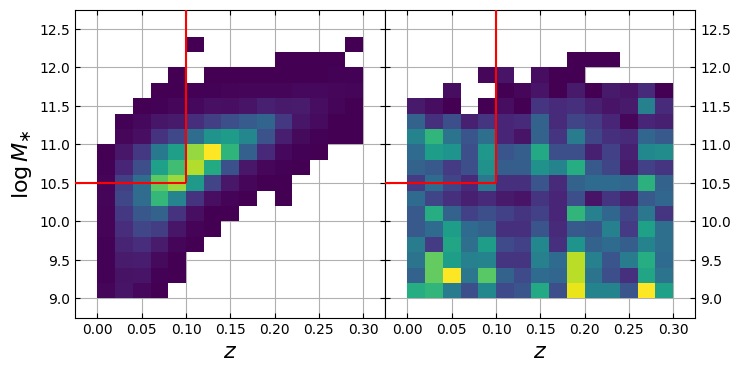

In [4]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0)
cmap = get_cmap('viridis')

# define mass and redshift bins
m_bins = np.linspace(9,12.6,num=18+1)
z_bins = np.linspace(0,0.3,num=15+1)

# choose our cuts
m_cut = 10.5
z_cut = 0.1

ax_sdss = fig.add_subplot(gs[0,0])
ax_sdss.hist2d(sdss_z, sdss_m, bins=(z_bins,m_bins),
               cmap=cmap, cmin=1, zorder=10)
ax_sdss.set_ylabel(r'$\log M_{\ast}$', size=16)
ax_sdss.set_xlabel(r'$z$', size=16)

ax_tng = fig.add_subplot(gs[0,1])
ax_tng.hist2d(tng_z, tng_m, bins=(z_bins,m_bins),
              cmap=cmap, cmin=1, zorder=10)
ax_tng.set_xlabel(r'$z$', size=16)
ax_tng.tick_params(labelleft=False, labelright=True)

for ax in [ax_sdss, ax_tng]:
    ax.tick_params(direction='in', top=True, right=True)
    ax.grid(True, zorder=-10)
    ax.set_xlim(-0.025, 0.325)
    ax.set_ylim(8.75, 12.75)
    ax.hlines([m_cut], ax.get_xlim()[0], z_cut, color='r', zorder=15)
    ax.vlines([z_cut], m_cut, ax.get_ylim()[1], color='r', zorder=15)
    
print('%5d SDSS galaxies' %(sum((sdss_m > m_cut) & (sdss_z < z_cut))))
print('%5d TNG galaxies' %(sum((tng_m > m_cut) & (tng_z < z_cut))))


In [5]:
# make selections

# for tng we just take all
tng_sel = np.where((tng_m > m_cut) & (tng_z < z_cut))[0]

# for sdss we pick 1000
rng = np.random.default_rng(seed=245)
sdss_sel = rng.choice(np.where((sdss_m > m_cut) & (sdss_z < z_cut))[0],
                      size=1000, replace=False)

In [6]:
with open('sel-scattering-tng-fnames.txt', 'w+') as f:
    for objid in tng_ids[tng_sel]:
        f.write('%s%d.fits\n' %(tng_prefix, objid))
        
with open('sel-scattering-sdss-fnames.txt', 'w+') as f:
    for objid in sdss_ids[sdss_sel]:
        f.write('sdss/reprojected_%d.fits\n' %(objid))

In [7]:
# sigma clipping function for calculating sky
def sigma_clip(data, alpha=3, tolerance=0.1, max_iterations=1000,
               verbose=False):
    """ Iterative sigma clipping function. Masks points outside alpha*sigma 
    of median and repeats until sigma of the clipped dataset is within 
    tolerance of the sigma of the previous iteration, or max_iterations has 
    been reached.
    
    Parameters
    ----------
    data : numpy.ndarray
        data to sigma clip
    alpha : float, default 3
        multiplier of sigma to clip at each iteration
    tolerance : float, default 0.1
        maximum allowed difference between sigma of current and previous 
        iteration for exit condition
    max_iterations : int, default 1000
        maximum number of iterations before exiting
    verbose : bool, default False
        whether to print information about the sigma-clipping process
    
    Returns
    -------
    mask : np.ndarray
        Boolean mask to get sigma-clipped data
    """
    
    # initialise stuff
    mask = np.ones(data.shape, dtype=bool)
    diff = tolerance
    count = 0
    old_sig = 0
    
    # perform clipping loops
    while (diff >= tolerance) and (count < max_iterations):
        med = np.nanmedian(data[mask])
        sig = np.nanstd(data[mask])
        
        mask[np.abs(data - med) > sig*alpha] = False

        # update exit criteria
        diff = np.abs(old_sig - sig)/sig
        old_sig = sig
        count += 1
        
    if verbose:
        print('Input size:       %d' %(data.flatten().shape[0]))
        print('Number of clips:  %d' %count)
        print('Final data size:  %d' %(np.sum(mask)))
        print('Median:           %g' %(np.nanmedian(data[mask])))
        print('Mean:             %g' %(np.nanmean(data[mask])))
        print('Sigma:            %g' %(np.nanstd(data[mask])))
        
    return mask

# wrapping that up to pass to the image renormalisation function below
def get_sky_from_sigma_med(img, alpha=2, tolerance=0.01, 
                           max_iterations=1000, verbose=False):
    """ Function to get the background level in an image from 
    the iteratively sigma-clipped median. Inputs same as sigma_clip
    
    Parameters
    ----------
    img : numpy.ndarray
        image 
    alpha : float, default 3
        multiplier of sigma to clip at each iteration
    tolerance : float, default 0.1
        maximum allowed difference between sigma of current and previous 
        iteration for exit condition
    max_iterations : int, default 1000
        maximum number of iterations before exiting
    verbose : bool, default False
        whether to print information about the sigma-clipping process
    
    Returns
    -------
    sky : float
        sky estimate
    """
    mask = sigma_clip(img, alpha=alpha, tolerance=tolerance,
                      verbose=verbose)
    sky = np.nanmedian(img[mask])
    return sky

# this function is bloody long but actually does the 

def renormalise_images(imarray, get_sky=np.nanmedian, get_sky_params=[],
                       get_sky_kwargs={}, bias=0.1, scale_func=np.log10,
                       saturate_func=np.nanpercentile,
                       saturate_args=[100]):
    """Renormalises the images between 0 and 1 with even sky levels across 
    images and bands.

    Parameters
    ----------
    imarray : numpy.ndarray
        array containing the images in (x,y,channels) form
    get_sky : function, default numpy.median
        function for obtaining the sky level from each image/band
    get_sky_params : list, default []
        list of parameters for the get_sky function
    get_sky_kwargs, dict, default {}
        keyword args for get_sky, use this instead!
    bias : float, default 0.1
        bias to add to sky-subtracted images
    scale_func : function, default numpy.log10
        function by which to rescale the images
    saturate_func : function, default np.nanpercentile
        function for choosing max value (aka value to saturate above)
    saturate_args : list, default [100]
        arguments for saturate_func
    Returns
    -------
    images : numpy.ndarray
        array containing renormalised images
    indices : np.ndarray
        array containing indices of successfully renormalised images
    """
    # 1. subtract sky
    
    n_bands = imarray.shape[-1]
    images = []
    indices = [] # indices into the imarray where we've had success
    for idx, img in enumerate(imarray):
        try:
            sub_img = []
            for i in range(n_bands):
                sub_img.append(img[:,:,i] - get_sky(img[:,:,i], *get_sky_params, **get_sky_kwargs))
            sub_img = np.moveaxis(np.array(sub_img), 0, 2)
            images.append(sub_img)
            indices.append(idx)
        except Exception:
            pass
    images = np.array(images)
    indices = np.array(indices)
    
    # 2. add bias
    
    images += bias
    
    # 3. clip bottom edge
    
    images[images < 0] = 0
    
    # 4. rescale
    
    images = scale_func(images)
    
    # 5. subtract mean so that it's zero
    
    images -= scale_func(bias)
    
    # 6. rescale to (-whatever, 1-mean)
    
    # images /= np.percentile(images, saturate_p)
    # I believe we want to do this per image
    images = np.array([img / saturate_func(img, *saturate_args)
                       for img in images])
    images *= 1 - scale_func(bias)
    
    # 7. add mean
    
    images += scale_func(bias)
    
    # 8. clip edges
    
    images[images < 0] = 0
    images[images > 1] = 1
    
    return images, indices


In [8]:
# def subtract_sky(img, sigma_clip_args={'alpha':2, 'tolerance':0.1}):
#     """ Function to subtract the sky from an image. 
    
#     PARAMETERS
#     ----------
#     img : numpy.ndarray
#         the image to look at
#     sigma_clip_args : dict, default {'alpha':2, 'tolerance':0.1}
#         args for sigma clipping 
        
#     RETURNS
#     -------
#     sky_subtracted : numpy.ndarray
#         the sky-subtracted image
#     """
    
#     sky_mask = sigma_clip(img, **sigma_clip_args)
#     sky = np.nanmedian(img[sky_mask])
#     sky_subtracted = img - sky
#     return sky_subtracted

In [9]:
def count_files_in_folder(folder_path):
    try:
        # List all items in the folder
        items = os.listdir(folder_path)
        # Filter the list to include only files
        files = [item for item in items if os.path.isfile(os.path.join(folder_path, item))]
        # Return the count of files
        return len(files)
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

In [15]:
n_img = count_files_in_folder('tng')
f_names=os.listdir('tng')
fig = plt.figure(figsize=(n_img*1.5,4.5))
gs = fig.add_gridspec(nrows=3, ncols=n_img, wspace=0, hspace=0)
plt.ioff()
#len(f_names)
for k,i in enumerate(f_names):
    with fits.open('tng/'+i) as hdul:
        for j in range(3):
            img = np.moveaxis(hdul[j+1].data[[2,1,0]],0,2)
            img = renormalise_images(
                np.array([img]),
                get_sky=get_sky_from_sigma_med,
                get_sky_kwargs={}, 
                bias=0.1, 
                scale_func=lambda x : np.log10(1+x),
                saturate_args = [99]
            )[0][0]
            file='{}_{}.png'.format(i[:-5],j)
            if float(hdul[0].header['dt_biggest']) < 0.5:
                plt.imsave('dataset/tng/merger/'+file, img)
            else:
                plt.imsave('dataset/tng/non_merger/'+file, img)
            plt.close(fig)
    print(((k+1)/n_img)*100, '%')
    

0.021486892995272885 %
0.04297378599054577 %
0.06446067898581864 %
0.08594757198109154 %
0.10743446497636443 %
0.12892135797163728 %
0.15040825096691018 %
0.17189514396218308 %
0.19338203695745596 %
0.21486892995272885 %
0.2363558229480017 %
0.25784271594327457 %
0.27932960893854747 %
0.30081650193382037 %
0.32230339492909327 %
0.34379028792436617 %
0.365277180919639 %
0.3867640739149119 %
0.40825096691018475 %
0.4297378599054577 %
0.45122475290073055 %
0.4727116458960034 %
0.49419853889127635 %
0.5156854318865491 %
0.5371723248818221 %
0.5586592178770949 %
0.5801461108723679 %
0.6016330038676407 %
0.6231198968629137 %
0.6446067898581865 %
0.6660936828534594 %
0.6875805758487323 %
0.7090674688440052 %
0.730554361839278 %
0.752041254834551 %
0.7735281478298238 %
0.7950150408250968 %
0.8165019338203695 %
0.8379888268156425 %
0.8594757198109154 %
0.8809626128061882 %
0.9024495058014611 %
0.9239363987967341 %
0.9454232917920068 %
0.9669101847872797 %
0.9883970777825527 %
1.0098839707778255

In [16]:
len(f_names)

4654

In [17]:
# looking at a few TNG images

# n_img = count_files_in_folder('tng')
# fig = plt.figure(figsize=(n_img*1.5,4.5))
# gs = fig.add_gridspec(nrows=3, ncols=n_img, wspace=0, hspace=0)
# plt.ioff()
# rng = np.random.default_rng(seed=524)
# for j, objid in enumerate(rng.choice(tng_ids[tng_sel], size=n_img, replace=False)):
#     with fits.open('%s%d.fits' %(tng_prefix, objid)) as hdul:
#         # 3 angles for each image
#         # note they live in extensions 1,2,3 
#         for i in range(3): 
#             # these images have griz filters
#             # here we show gri (reverse to get rgb)
#             img = np.moveaxis(hdul[i+1].data[[2,1,0]],0,2)
#             img = renormalise_images(
#                 np.array([img]),
#                 get_sky=get_sky_from_sigma_med,
#                 get_sky_kwargs={}, 
#                 bias=0.1, 
#                 scale_func=lambda x : np.log10(1+x),
#                 saturate_args = [99]
#             )[0][0]
#             # ax = fig.add_subplot(gs[i,j])
#             # ax.imshow(img)
#             # ax.set_xticks([])
#             # ax.set_yticks([])
            
#             file='{}{}_{}.png'.format(tng_prefix[4:], objid, i)
            
#             if float(hdul[0].header['dt_biggest']) < 0.5:
#                 #ax.set_xlabel('merger', size=14)dataset/tng/merger
#                 plt.imsave('dataset/tng/merger'+file, img)
#             else:
#                 #ax.set_xlabel('nonmerger', size=14)
#                 plt.imsave('dataset/tng/non_merger'+file, img)
#             plt.close(fig)
#     print(((j+1)/n_img)*100, '%')

In [10]:
# to show the info that lives in headers:
fits.getheader('%s%d.fits' %(tng_prefix, objid))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
HIERARCH subhaloID = 290209                                                     
HIERARCH snapshot =                   92                                        
HIERARCH redshift =   0.0838844307974793                                        
HIERARCH lookback_time = 1.140077804287315 / from Planck 2015 cosmology         
HIERARCH partType = 'stars   '                                                  
HIERARCH partField = 'stellarBandObsFrame-sdss_X' / Indexed 01234 = ugriz       
HIERARCH size =                    8                                            
HIERARCH sizeType = 'rHalfMassStars'                                            
HIERARCH method = 'sphMap  '

In [11]:
# each angle has the info for the background
fits.getheader('%s%d.fits' %(tng_prefix, objid), ext=1)

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  169                                                  
NAXIS2  =                  169                                                  
NAXIS3  =                    4                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
RUN_G   =                 4003 / SDSS image RUN                                 
RERUN_G =                   40 / SDSS image RERUN                               
CAMCOL_G=                    4 / SDSS image CAMCOL                              
FIELD_G =                   85 / SDSS image FIELD                               
COLC_G  =                  6

In [19]:
# and a few SDSS images

# n_img = 1000
# fig = plt.figure(figsize=(15,4.495))
# gs = fig.add_gridspec(nrows=3, ncols=10, wspace=0, hspace=0)


# rng = np.random.default_rng(seed=524)
# k=0
# for j, objid in enumerate(rng.choice(sdss_ids[sdss_sel], size=n_img, replace=False)):
# # for (i,j), objid in zip(np.ndindex((3,10)),
# #                         rng.choice(sdss_ids[sdss_sel],
# #                                          size=n_img, replace=False)):
#     with fits.open('%s%d.fits' %(sdss_prefix, objid)) as hdul:
#         # these images live in the first extension
#         # these images have griz filters
#         # here we show gri (reverse to get rgb)
#         img = np.moveaxis(hdul[0].data[[2,1,0]],0,2)
#         img = renormalise_images(
#             np.array([img]),
#             get_sky=get_sky_from_sigma_med,
#             get_sky_kwargs={}, 
#             bias=0.1, 
#             scale_func=lambda x : np.log10(1+x),
#             saturate_args = [99]
#         )[0][0]
#         # ax = fig.add_subplot(gs[i,j])
#         # ax.imshow(img)
#         # ax.set_xticks([])
#         # ax.set_yticks([])
        
#     file='{}{}.png'.format(sdss_prefix[5:], objid)
#     print(file) 
#     plt.imsave('/mnt/c/Users/Rwitobaan/Desktop/Dissertation/scattering/scattering/scattering_data_set/sdss/'+file, img)
#     #plt.close(fig)
#     k+=1
#     print(((k)/n_img)*100, '%') 
    

In [20]:
n_img=count_files_in_folder('sdss')
f_names=os.listdir('sdss')
fig = plt.figure(figsize=(15,4.495))
gs = fig.add_gridspec(nrows=3, ncols=10, wspace=0, hspace=0)
for k,i in enumerate(f_names):
    with fits.open('sdss/'+i) as hdul:
        img = np.moveaxis(hdul[0].data[[2,1,0]],0,2)
        img = renormalise_images(
            np.array([img]),
            get_sky=get_sky_from_sigma_med,
            get_sky_kwargs={}, 
            bias=0.1, 
            scale_func=lambda x : np.log10(1+x),
            saturate_args = [99]
        )[0][0]
        file='{}{}'.format(i[:-5],'.png')
        plt.imsave('dataset/sdss/'+file, img)
        plt.close(fig)
    print(((k+1)/n_img)*100, '%')

0.0058889346917142685 %
0.011777869383428537 %
0.017666804075142806 %
0.023555738766857074 %
0.029444673458571345 %
0.03533360815028561 %
0.04122254284199988 %
0.04711147753371415 %
0.05300041222542842 %
0.05888934691714269 %
0.06477828160885696 %
0.07066721630057123 %
0.0765561509922855 %
0.08244508568399976 %
0.08833402037571403 %
0.0942229550674283 %
0.10011188975914258 %
0.10600082445085685 %
0.11188975914257111 %
0.11777869383428538 %
0.12366762852599965 %
0.12955656321771392 %
0.1354454979094282 %
0.14133443260114245 %
0.1472233672928567 %
0.153112301984571 %
0.15900123667628524 %
0.16489017136799952 %
0.1707791060597138 %
0.17666804075142806 %
0.18255697544314234 %
0.1884459101348566 %
0.19433484482657087 %
0.20022377951828516 %
0.20611271420999938 %
0.2120016489017137 %
0.21789058359342794 %
0.22377951828514223 %
0.22966845297685648 %
0.23555738766857076 %
0.24144632236028502 %
0.2473352570519993 %
0.2532241917437136 %
0.25911312643542783 %
0.2650020611271421 %
0.27089099581885

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


15.841234320711383 %
15.847123255403098 %
15.853012190094812 %
15.858901124786525 %
15.86479005947824 %
15.870678994169953 %
15.876567928861668 %
15.882456863553381 %
15.8883457982451 %
15.894234732936813 %
15.900123667628527 %
15.90601260232024 %
15.911901537011955 %
15.917790471703668 %
15.923679406395383 %
15.929568341087098 %
15.93545727577881 %
15.941346210470526 %
15.947235145162239 %
15.953124079853954 %
15.95901301454567 %
15.964901949237383 %
15.970790883929098 %
15.976679818620813 %
15.982568753312526 %
15.98845768800424 %
15.994346622695954 %
16.00023555738767 %
16.006124492079383 %
16.012013426771095 %
16.01790236146281 %
16.023791296154528 %
16.029680230846242 %
16.035569165537954 %
16.04145810022967 %
16.047347034921383 %
16.053235969613098 %
16.05912490430481 %
16.065013838996524 %
16.07090277368824 %
16.076791708379954 %
16.08268064307167 %
16.08856957776338 %
16.0944585124551 %
16.100347447146813 %
16.106236381838528 %
16.11212531653024 %
16.118014251221954 %
16.123903

In [23]:
# and the SDSS cutout headers
fits.getheader('sdss/{}.fits'.format(f_names[0][:-5]))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   68                                                  
NAXIS2  =                   68                                                  
NAXIS3  =                    4                                                  
EXTEND  =                    T                                                  
HIERARCH Unnamed: 0 = 611654                                                    
RA      =             243.4753                                                  
DEC     =            44.741966                                                  
PLATEID =                  814                                                  
FIBERID =                  190                                                  
MJD     =                524

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])



In [11]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),normalize])

In [12]:

tng_set=dset.ImageFolder('dataset/tng',transform=transform)
tng_loader=torch.utils.data.DataLoader(tng_set, shuffle=True, pin_memory=True)


In [13]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

sdss_set = CustomImageDataset('dataset/sdss', transform=transform)
sdss_loader = DataLoader(sdss_set, shuffle=False, pin_memory=True)

In [14]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
tng_ims = [ i.to(device) for i,j in tng_loader]
tng_labels = [ j for i,j in tng_loader]

In [16]:
sdss_ims = [ i.to(device) for i in sdss_loader]

In [17]:
sc = Scattering2D(J=3,shape=(32,32)).to(device)
print(tng_ims[0].shape)
# tng_ims[0].is_contiguous()
print(tng_ims[0].is_contiguous())
sc_ims = sc(tng_ims[0]).to(device)
print(sc_ims.shape)


torch.Size([1, 3, 32, 32])
True
torch.Size([1, 3, 217, 4, 4])


In [18]:
plt.ion()

In [18]:
best_l2_indices=[]
best_sc_l2_inds = []
best_sc_l1_inds = []
ttng_ims = torch.concatenate(tng_ims).to(device)
scttest_ims = sc(ttng_ims).to(device)

for im in tqdm.tqdm(sdss_ims):
    im=im.to(device)
    scim = sc(im).to(device)
    
    l2_distances = ((im - ttng_ims) ** 2).sum((-1, -2, -3))
    sorted_l2_indices = l2_distances.argsort()
    best_l2_indices.append(sorted_l2_indices[:5].cpu().numpy())
    
    sc_l2_distances = ((scim - scttest_ims) ** 2).sum((-1, -2, -3, -4))
    sorted_sc_l2_indices = sc_l2_distances.argsort()
    best_sc_l2_inds.append(sorted_sc_l2_indices[:5].cpu().numpy())
    
    sc_l1_distances = torch.abs(scim - scttest_ims).sum((-1, -2, -3, -4))
    sorted_sc_l1_indices = sc_l1_distances.argsort()
    best_sc_l1_inds.append(sorted_sc_l1_indices[:5].cpu().numpy())

100%|██████████| 16981/16981 [32:32<00:00,  8.69it/s]


In [19]:
sdss_ims=[i.to('cpu') for i in sdss_ims]
tng_ims=[i.to('cpu') for i in tng_ims]

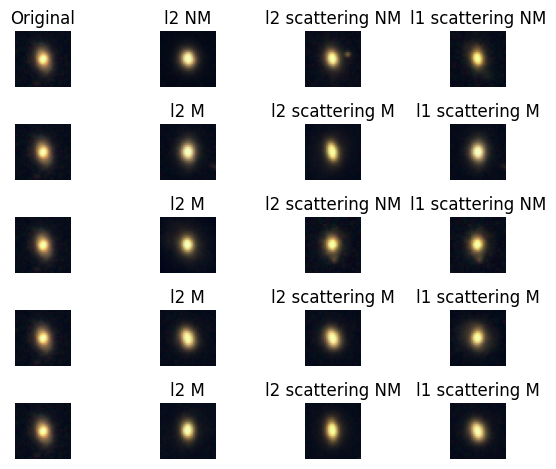

In [83]:
ind = 1052
fix,axes = plt.subplots(5,4)
axes[0,0].set_title("Original")
axes[0,1].set_title("l2")
axes[0,2].set_title("l2 on scattering")
axes[0,3].set_title("l1 on scattering")
orig = sdss_ims[ind].squeeze().numpy().transpose(1,2,0)
orig = orig - orig.min()
orig = orig / orig.max()

l2_arr=[]
l2_arr_imgs=[]
l2_arr_labels=[]
l2_on_scattering_arr=[]
l2_on_scatter_imgs=[]
l2_on_scatter_labels=[]
l1_on_scattering_arr=[]
l1_on_scatter_imgs=[]
l1_on_scatter_labels=[]
for i in range (5):
    axes[i,0].imshow(orig); axes[i,0].axis('off')

    l2im = tng_ims[best_l2_indices[ind][i]].squeeze().numpy().transpose(1,2,0)
    l2im = l2im - l2im.min()
    l2im = l2im / l2im.max()
    label_l2=""
    label_l2_scatter=""
    label_l1_scatter=""
    l2_arr.append(tng_loader.dataset.samples[best_l2_indices[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_l2_indices[ind][i]][0]:
        label_l2 = 'M'
    else:
        label_l2 = 'NM'
    l2_arr_labels.append(label_l2)
    axes[i,1].imshow(l2im); axes[i,1].axis('off'); axes[i,1].set_title(f"l2 {label_l2}")
    l2_arr_imgs.append(l2im)
    
    scim2 = tng_ims[best_sc_l2_inds[ind][i]].squeeze().numpy().transpose(1,2,0)
    scim2 = scim2 - scim2.min()
    scim2 = scim2 / scim2.max()
    l2_on_scattering_arr.append(tng_loader.dataset.samples[best_sc_l2_inds[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_sc_l2_inds[ind][i]][0]:
        label_l2_scatter = 'M'
    else:
        label_l2_scatter = 'NM'
    l2_on_scatter_labels.append(label_l2_scatter)
    axes[i,2].imshow(scim2); axes[i,2].axis('off'); axes[i,2].set_title(f"l2 scattering {label_l2_scatter}")
    l2_on_scatter_imgs.append(scim2)
    
    scim1 = tng_ims[best_sc_l1_inds[ind][i]].squeeze().numpy().transpose(1,2,0)
    scim1 = scim1 - scim1.min()
    scim1 = scim1 / scim1.max()
    l1_on_scattering_arr.append(tng_loader.dataset.samples[best_sc_l1_inds[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_sc_l1_inds[ind][i]][0]:
        label_l1_scatter = 'M'
    else:
        label_l1_scatter = 'NM'
    l1_on_scatter_labels.append(label_l1_scatter)
    axes[i,3].imshow(scim1); axes[i,3].axis('off'); axes[i,3].set_title(f"l1 scattering {label_l1_scatter}")
    l1_on_scatter_imgs.append(scim1)
    
plt.tight_layout()


In [32]:
import pickle

with open('best_l2_indices.pkl', 'wb') as f:
    pickle.dump(best_l2_indices, f)
    
with open('best_sc_l2_inds.pkl', 'wb') as f:
    pickle.dump(best_sc_l2_inds, f)
    
with open('best_sc_l1_inds.pkl', 'wb') as f:
    pickle.dump(best_sc_l1_inds, f)
    
with open('tng_ims.pkl', 'wb') as f:
    pickle.dump(tng_ims, f)
    
with open('sdss_ims.pkl', 'wb') as f:
    pickle.dump(sdss_ims, f)
    
with open('sdss_loader.pkl', 'wb') as f:
    pickle.dump(sdss_loader, f)
    
with open('tng_loader.pkl', 'wb') as f:
    pickle.dump(tng_loader, f)

In [30]:
l2_arr

['FullReal_8R_970226597',
 'FullReal_8R_910373624',
 'FullReal_8R_940287345',
 'FullReal_8R_990330208',
 'FullReal_8R_970226595']

In [31]:
l2_on_scattering_arr

['FullReal_8R_910373624',
 'FullReal_8R_970226597',
 'FullReal_8R_990330208',
 'FullReal_8R_970226595',
 'FullReal_8R_920409017']

In [32]:
l1_on_scattering_arr

['FullReal_8R_910373624',
 'FullReal_8R_970226597',
 'FullReal_8R_940287345',
 'FullReal_8R_970226595',
 'FullReal_8R_950457184']

In [78]:
best_l2_indices[3][0]

710

In [27]:
s=tng_loader.dataset.samples[best_sc_l2_inds[ind][3]][0].split('/')[-1][:-6]

In [58]:
l2_arr_labels

['M', 'M', 'M', 'M', 'M']

In [26]:
s.split('/')[-1][:-6]

'FullReal_8R_970226595'

In [80]:
from sklearn.neighbors import KNeighborsClassifier as knn

knn = knn(n_neighbors=5)

orig_flatenned = orig.flatten().reshape(1,-1)
l2_arr_imgs_flattened = np.array([i.flatten() for i in l2_arr_imgs])

knn.fit(l2_arr_imgs_flattened, l2_arr_labels)

predicted_label = knn.predict(orig_flatenned)

print("L2 norm prediction: ",predicted_label)

L2 norm prediction:  ['M']


In [81]:
l2_on_scatter_imgs_flattened = np.array([i.flatten() for i in l2_on_scatter_imgs])

knn.fit(l2_on_scatter_imgs_flattened, l2_on_scatter_labels)

print("L2 on scattering prediction: ",knn.predict(orig_flatenned))

L2 on scattering prediction:  ['M']


In [82]:
l1_on_scatter_imgs_flattened = np.array([i.flatten() for i in l1_on_scatter_imgs])

knn.fit(l1_on_scatter_imgs_flattened, l1_on_scatter_labels)

print("L1 on scattering prediction: ",knn.predict(orig_flatenned))

L1 on scattering prediction:  ['NM']


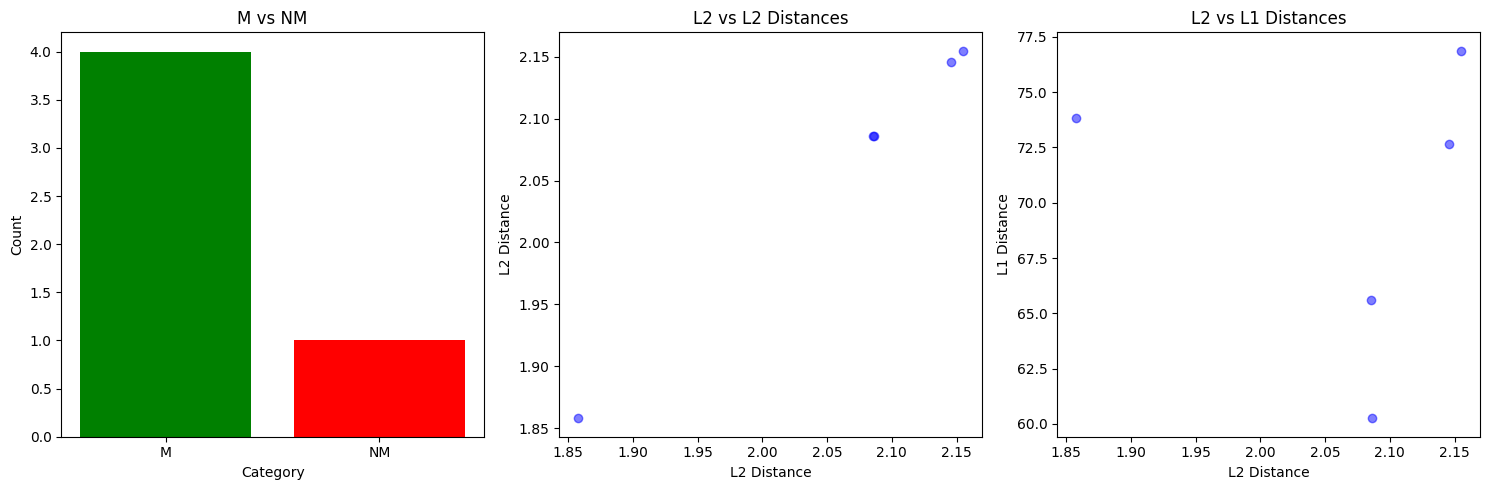

In [84]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn
import numpy as np

# Assuming orig, l2_arr_imgs, l2_arr_labels, l2_on_scatter_imgs, and l1_on_scatter_imgs are numpy arrays
# Example:
# orig = np.array([...])  # Original image array
# l2_arr_imgs = np.array([...])  # Array of images to compare for M vs NM
# l2_arr_labels = np.array([...])  # Corresponding labels for l2_arr_imgs
# l2_on_scatter_imgs = np.array([...])  # Array of images for L2 vs L2 scatter plot
# l1_on_scatter_imgs = np.array([...])  # Array of images for L2 vs L1 scatter plot

# Flatten the orig image to convert it into a feature vector
orig_flattened = orig.flatten().reshape(1, -1)

# Flatten each image in l2_arr_imgs and stack them into a 2D array
l2_arr_imgs_flattened = np.array([img.flatten() for img in l2_arr_imgs])

# Initialize the KNeighborsClassifier model
knn_model = knn(n_neighbors=5)

# Fit the model on the flattened l2_arr_imgs data
knn_model.fit(l2_arr_imgs_flattened, l2_arr_labels)

# Predict the label for the flattened orig image
predicted_label = knn_model.predict(orig_flattened)

# Count matches (M) and non-matches (NM)
matches = np.sum(predicted_label == l2_arr_labels)
non_matches = len(l2_arr_labels) - matches

# Calculate L2 and L1 distances for scatter plots
l2_on_scatter_flattened = np.array([img.flatten() for img in l2_on_scatter_imgs])
l1_on_scatter_flattened = np.array([img.flatten() for img in l1_on_scatter_imgs])

l2_distances = np.linalg.norm(l2_on_scatter_flattened - orig_flattened, axis=1)
l1_distances = np.sum(np.abs(l1_on_scatter_flattened - orig_flattened), axis=1)

# Plotting the bar graph for M vs NM
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
labels = ['M', 'NM']
counts = [matches, non_matches]
plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('M vs NM')

# Plotting the scatter plot for L2 vs L2 distances
plt.subplot(1, 3, 2)
plt.scatter(l2_distances, l2_distances, c='blue', alpha=0.5)
plt.xlabel('L2 Distance')
plt.ylabel('L2 Distance')
plt.title('L2 vs L2 Distances')

# Plotting the scatter plot for L2 vs L1 distances
plt.subplot(1, 3, 3)
plt.scatter(l2_distances, l1_distances, c='blue', alpha=0.5)
plt.xlabel('L2 Distance')
plt.ylabel('L1 Distance')
plt.title('L2 vs L1 Distances')

plt.tight_layout()
plt.show()

In [108]:
tng_label_values=np.array([ i.item() for i in tng_labels])
type(tng_label_values[0])

numpy.int64

Number of mergers: 7131


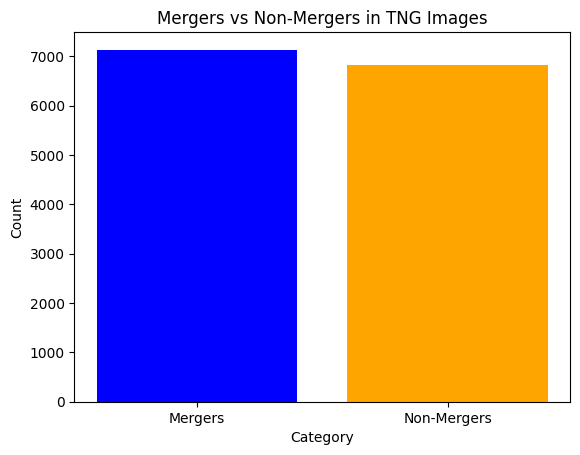

In [109]:
mergers = np.sum(tng_label_values == 1)
non_mergers = np.sum(tng_label_values == 0)

print("Number of mergers:", mergers)

# Plotting the bar graph for mergers vs non-mergers
labels = ['Mergers', 'Non-Mergers']
counts = [mergers, non_mergers]

plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Mergers vs Non-Mergers in TNG Images')
plt.show()